In [230]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  np.array(ftcw['rel']) 

precip_all = ftcw['prcp_hist']

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

In [40]:
print('Shear scaling', shearfac)
print('TCW scaling', tcwvfac_all)

Shear scaling 0.7003135334190702
TCW scaling [1.16296269 1.14583054 1.16296269 1.19185658 1.10917452 1.16007311
 1.09546043 1.1853091  1.13894869 1.32547751 1.20666992 1.30495387
 1.22251442 1.3176084  1.23383721 1.26747419 1.46585397 1.32938129
 1.4510043  1.45911276]


In [268]:
ftcw

{'rel': array([1.16296269, 1.14583054, 1.16296269, 1.19185658, 1.10917452,
        1.16007311, 1.09546043, 1.1853091 , 1.13894869, 1.32547751,
        1.20666992, 1.30495387, 1.22251442, 1.3176084 , 1.23383721,
        1.26747419, 1.46585397, 1.32938129, 1.4510043 , 1.45911276]),
 'abs': [1.4703788751984475,
  1.1938972394584302,
  1.168893468170798,
  1.1898706697993975,
  1.1554952615026859,
  1.1928813898435546,
  1.1107330531476685,
  1.170165853726141,
  1.1527210158119878,
  1.2754827256642673,
  1.1722203998563108,
  1.2479030289406612,
  1.1749292208303013,
  1.224513037936488,
  1.1844271554845258,
  1.2094912358781642,
  1.3202586825401474,
  1.212052767412634,
  1.3035634296150307,
  1.205227966220739],
 'futslope': 0.6859065709797977,
 'histslope': 0.49638498012944865,
 'futinter': 22.438128945665746,
 'histinter': 20.434819209386152,
 'tcw_hist': array([28.28, 35.06, 36.94, 38.26, 39.34, 40.3 , 41.14, 41.9 , 42.63,
        43.31, 43.95, 44.56, 45.19, 45.83, 46.5 , 47.23, 4

In [146]:
def calc_mcs_stuff(dic):
    m1=7
    m2=9
    domain=[-2.52,0.52,11.38,13.38]
    dicout = dic[(dic.lon>=domain[0])&(dic.lon<=domain[1])&(dic.lat>=domain[2])&(dic.lat<=domain[3])& (dic.month>=m1) & (dic.month<=m2) & (dic.q925>=8.) & (dic.shear>0) &  (dic.prcp>=8) & (dic.theta_e>=-40) & (dic.area>=5000) & (dic.tmin<=-55)]
    return dicout

In [207]:
obs_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/obs_MCS_fig2.p', "rb"))
cp4hist_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4hist_MCS_fig2_5-20N.p', "rb"))
cp4fut_mcs_d = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/cp4fut_MCS_fig2_5-20N.p', "rb"))

In [208]:
obs_mcs = calc_mcs_stuff(obs_mcs_d).quantile(0.95)
cp4hist_mcs = calc_mcs_stuff(cp4hist_mcs_d).quantile(0.95)
cp4fut_mcs = calc_mcs_stuff(cp4fut_mcs_d).quantile(0.95)

In [210]:
cp4hist_mcs

prcp           43.883661
q925           16.407143
t925           30.050000
tcwv           52.061997
tgrad           0.039980
tbox            7.690034
shear          23.071429
month           9.000000
area        90411.200000
tmin          -64.159981
tmean         -55.912646
lat            13.301252
lon             0.366989
theta_es       57.786587
theta_e        13.124059
Name: 0.95, dtype: float64

In [211]:
cp4fut_mcs-cp4hist_mcs

prcp          30.247236
q925           5.400248
t925           5.480000
tcwv          22.615674
tgrad          0.005932
tbox           0.773570
shear          1.270483
month          0.000000
area        7472.960000
tmin           3.419959
tmean          1.254817
lat           -0.020250
lon            0.000015
theta_es      24.560669
theta_e        0.543850
Name: 0.95, dtype: float64

In [157]:
ftcw.keys()

dict_keys(['rel', 'abs', 'futslope', 'histslope', 'futinter', 'histinter', 'tcw_hist', 'prcp_hist'])

In [162]:
cp4_tcw_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_tcwv_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_tcw_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_tcwv_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_prcp_fut = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_p95Rain_gt5mm.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_prcp_hist = xr.open_dataarray('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_p95Rain_gt5mm.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()

In [163]:
#plt.contourf(cp4_prcp_fut-cp4_prcp_hist, cmap='jet', levels=np.arange(15,61,2))

In [164]:
cp4_u925_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u925_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_u925_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u925_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_u600_hist = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4hist_u600_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()
cp4_u600_fut = xr.open_dataset('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CP4fut_u600_daily.nc').sel(longitude=slice(-2.52,0.52), latitude=slice(11.38,13.38)).mean()

In [187]:
cp4_shear_hist = cp4_u925_hist-cp4_u600_hist
cp4_shear_fut = cp4_u925_fut-cp4_u600_fut

In [261]:
cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist
cp4_tcw = (cp4_tcw_fut-cp4_tcw_hist)#/cp4_tcw_hist

In [192]:
cp4_shear_abs = cp4_shear_fut-cp4_shear_hist

In [193]:
cp4_shear_abs

<xarray.Dataset>
Dimensions:                  ()
Coordinates:
    forecast_reference_time  object 1997-01-01 00:00:00
Data variables:
    u_pl                     float32 2.4713478

In [166]:
cp4_prcp_fut.name = 'prcp'
cp4_prcp_hist.name = 'prcp'

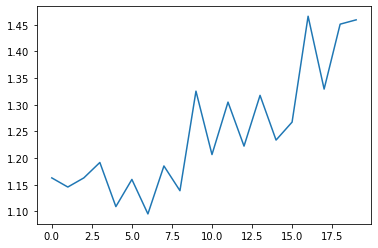

In [167]:
plt.plot(tcwvfac_all)

In [274]:
isclose = np.nanargmin(np.abs(cp4hist_mcs['tcwv']-ftcw['tcw_hist']))#(np.abs(cp4_tcw_hist['tcwv'].values-ftcw['tcw_hist']))
cp4_pos_array = tcwvfac_all[isclose]
cp4_prcp_array = ftcw['prcp_hist'][isclose]

In [281]:
cp4_pos_array

1.451004302507888

In [276]:
cp4_tcw_hist['tcwv'].values

array(45.939575, dtype=float32)

In [277]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model_name', combine='by_coords').load()

In [278]:
model_names = cmip_tcw_map.model_name

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

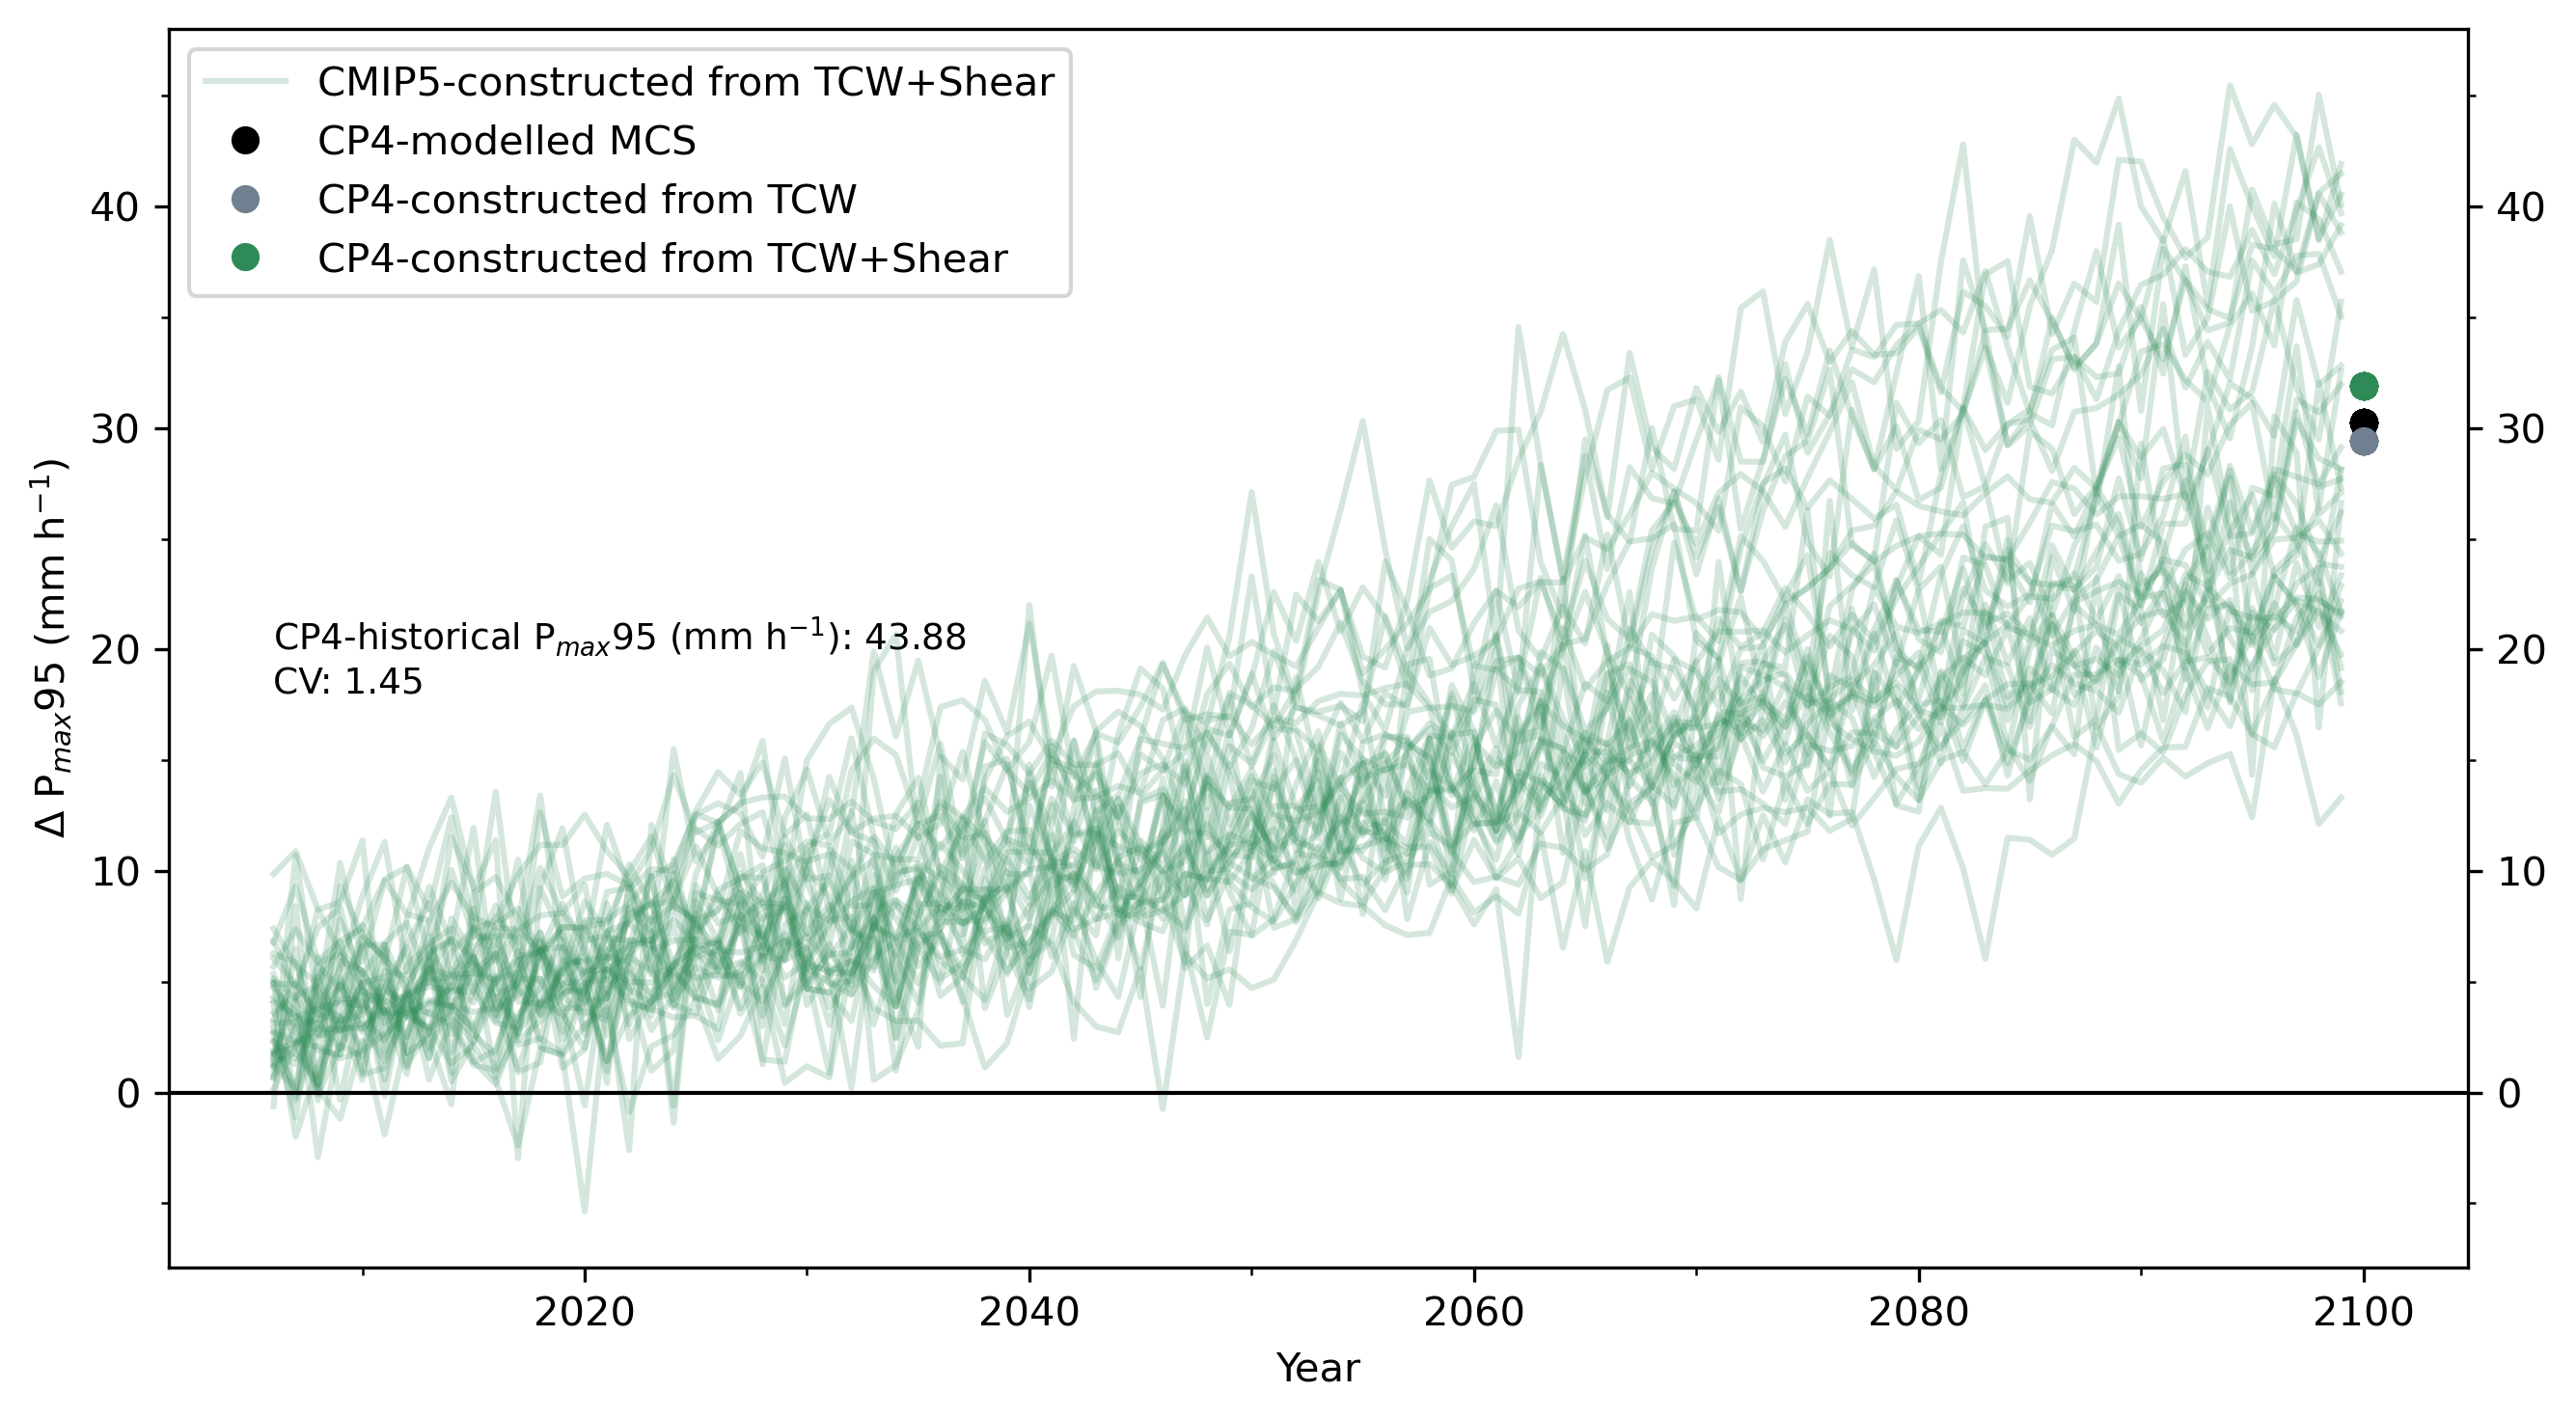

In [279]:


notfinite = np.isnan(cp4_pos_array)
f = plt.figure(figsize=(9,5), dpi=300)


ax = f.add_subplot(1,1,1)  #cp4f_mcs_grid-

slevels=np.arange(-18,19,3)
tag='10'
yy ='2020-2100'
#ipdb.set_trace()
evenly_spaced_interval = np.linspace(0, 1, len(model_names))

colors = [cm.inferno(x) for x in evenly_spaced_interval]
for ids, mn in enumerate(model_names.values):
    tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
    sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*_'+mn+'_*.nc')[0]).squeeze()
    
    tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
    sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)
    
    #ds_merge = xr.merge([tcw_map, sh_map])

    ##relative CMIP change
    ds_shear = sh_map['unknown']*shearfac
    cmip_rel = (tcw_map['prw']/tcw_map['prw_hist'])

    years = np.unique(tcw_map['time.year'].values)

   # ipdb.set_trace()
    new_ar_list =   cmip_rel *cp4_pos_array * cp4hist_mcs['prcp']
    sums = new_ar_list + ds_shear
    if len(sums)>95:
        ipdb.set_trace()
        
    cp4construct =  cp4hist_mcs['prcp'] * cp4_pos_array * cp4_tcw_rel['tcwv']
    cp4total = cp4construct + cp4_shear_abs['u_pl']
        
    ax.plot(tcw_map['time.year'].values,sums, color='seagreen', alpha=0.2, label='CMIP5-constructed from TCW+Shear')
    #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
    #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
    ax.plot(2100, cp4fut_mcs['prcp']-cp4hist_mcs['prcp'], marker='o', linestyle='', color='k', label='CP4-modelled MCS')
    ax.plot(2100, cp4construct, marker='o', color='slategrey', linestyle='', label='CP4-constructed from TCW')
    ax.plot(2100, cp4total, marker='o', color='seagreen', linestyle='', label='CP4-constructed from TCW+Shear')
    
    if ids==0:
        plt.legend()
    
ax.text(2006,20,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs['prcp'],2)), fontsize=9)
#ax.text(2006,18,'CP4 $\Delta$TCW (%): '+str(np.round(cp4_tcw_rel['tcwv'].values*100,2)), fontsize=8)
ax.text(2006,18,'CV: '+str(np.round(cp4_pos_array,2)), fontsize=9)
ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
ax.set_xlabel('Year')
ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.axhline(0, linestyle='solid', lw=1, color='k')



    
    #     new_ar_list.name = 'prw'
    #     ar_list.append(new_ar_list)

    # ds_scaled = xr.concat(ar_list, dim='model_name')
    # ds_merge['sum'] =  ds_shear +ds_scaled  #
    # ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

    # 
    # for mids in ds_merge['prw'].model_name:
    #     ax.plot(years, ds_merge['sum'].sel(model_name=mids))

plt.tight_layout()

f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_Ouagadougou_timeseries_CP4_8mm.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

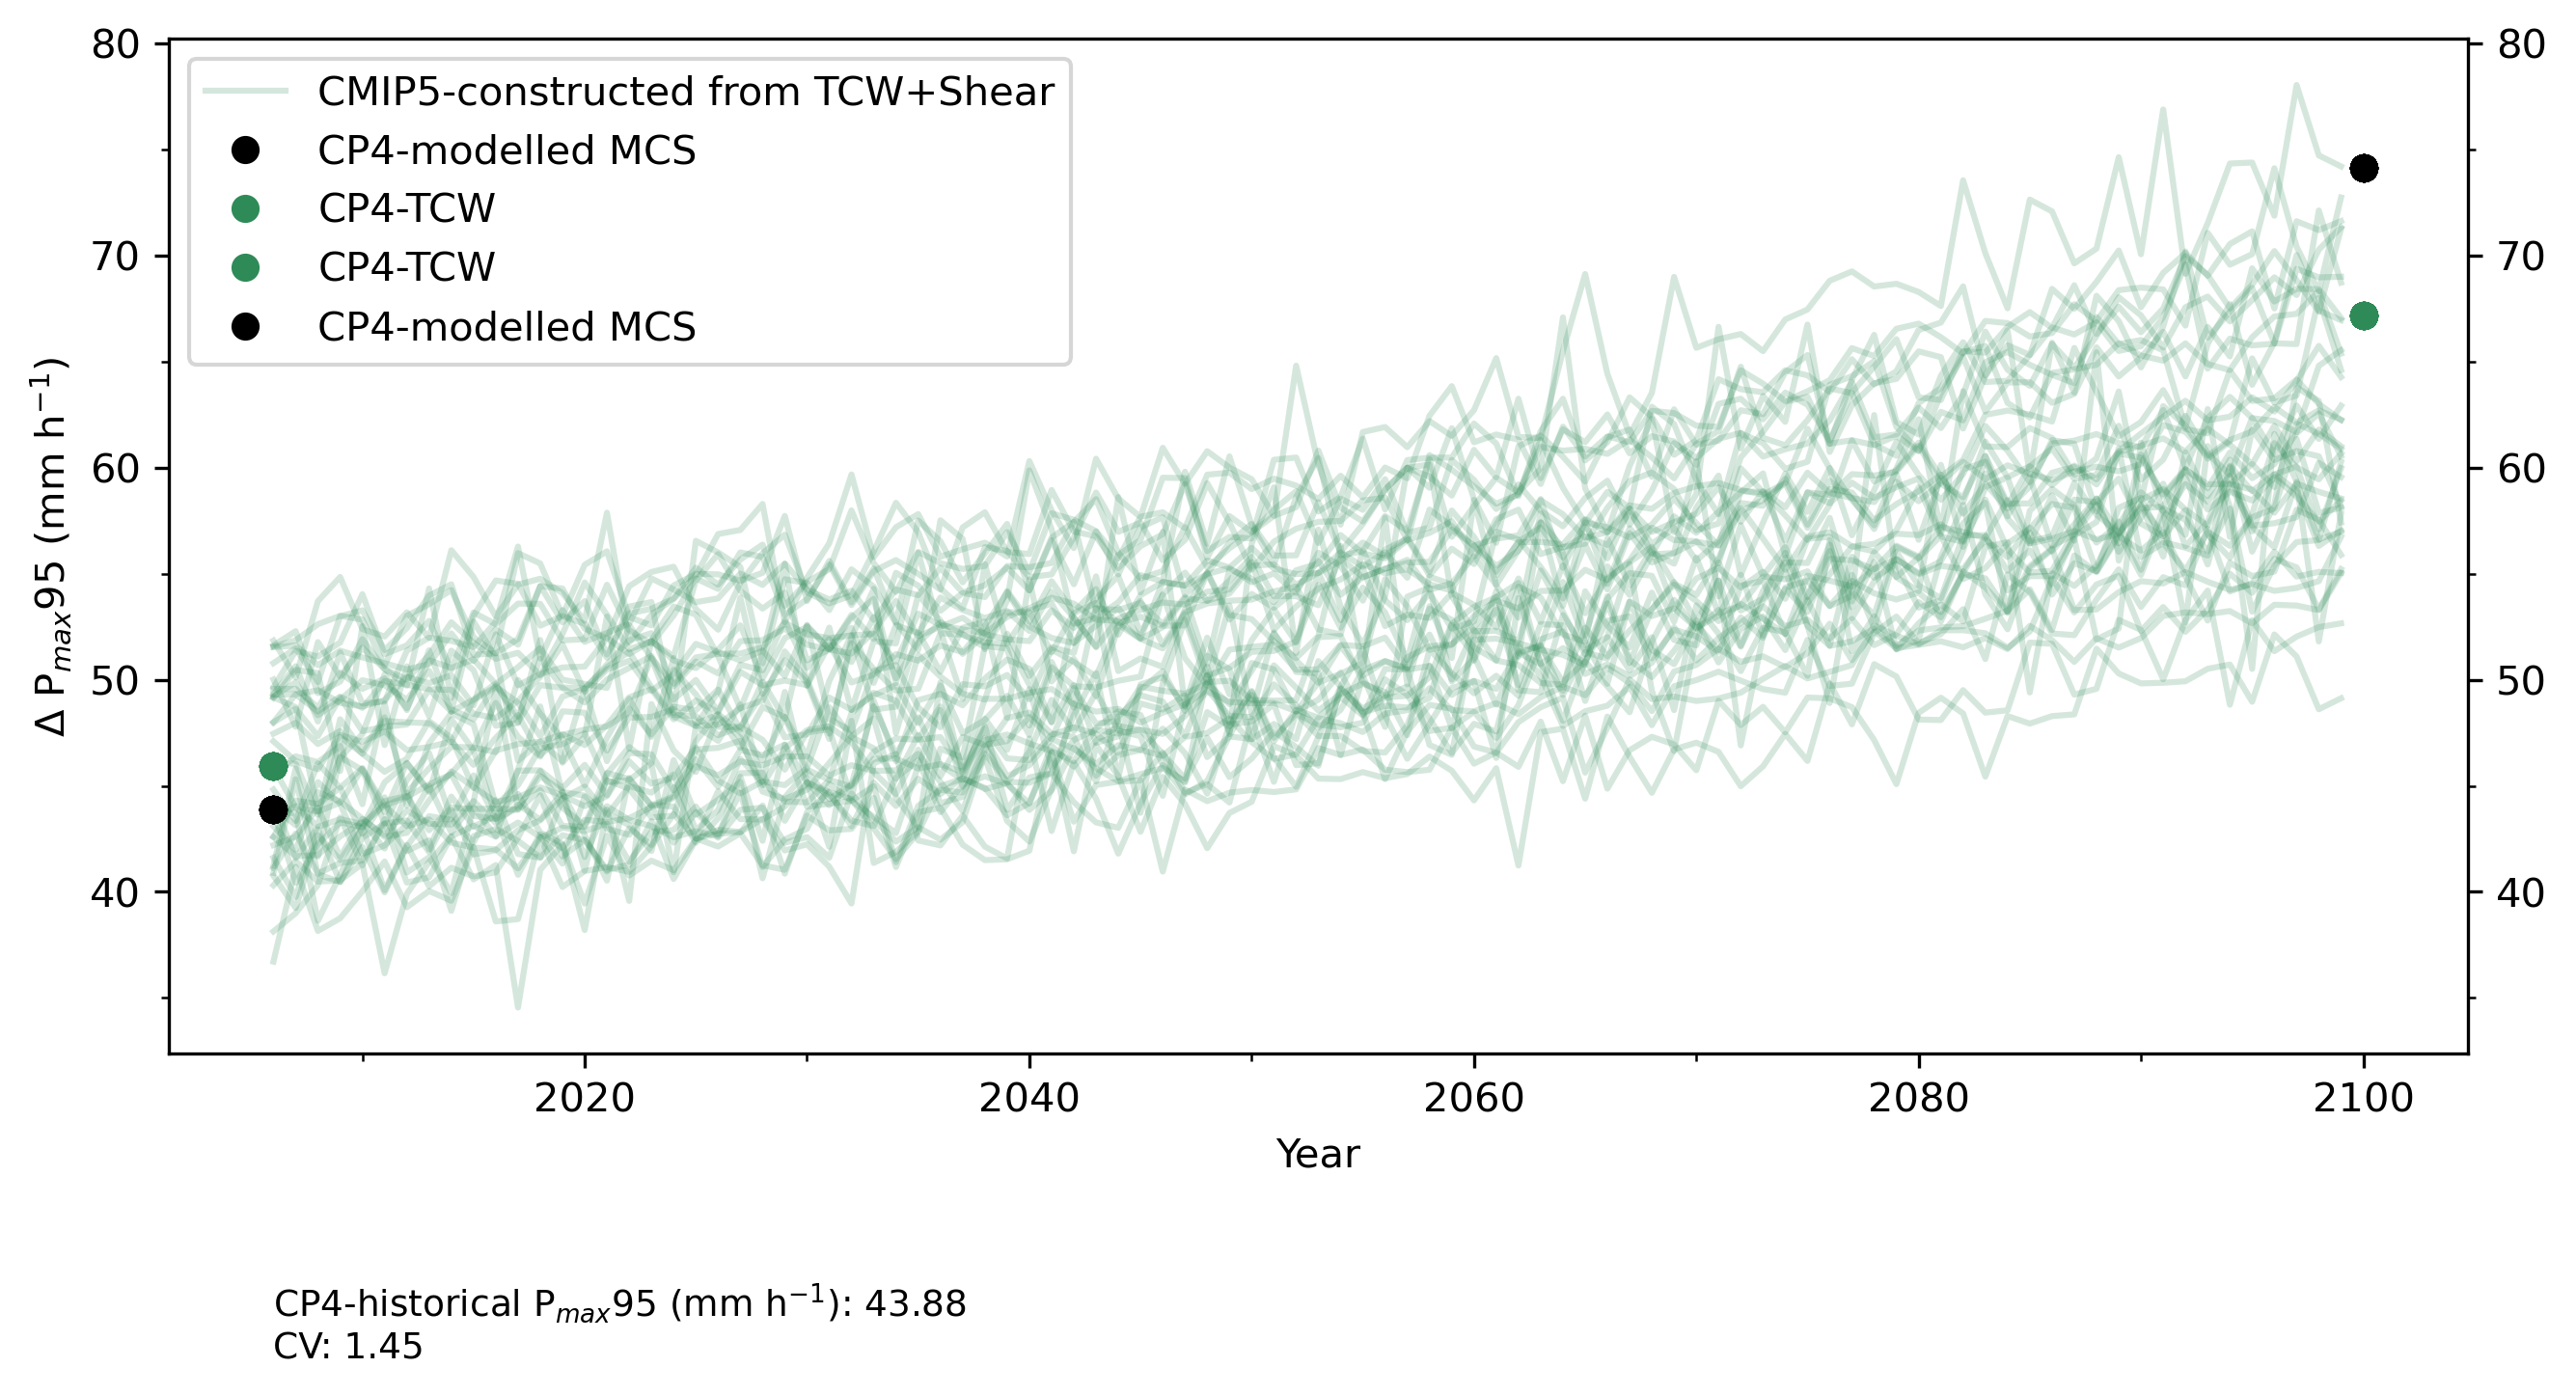

In [282]:


notfinite = np.isnan(cp4_pos_array)
f = plt.figure(figsize=(9,5), dpi=300)


ax = f.add_subplot(1,1,1)  #cp4f_mcs_grid-

slevels=np.arange(-18,19,3)
tag='10'
yy ='2020-2100'
#ipdb.set_trace()
evenly_spaced_interval = np.linspace(0, 1, len(model_names))

colors = [cm.inferno(x) for x in evenly_spaced_interval]
for ids, mn in enumerate(model_names.values):
    tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
    sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*_'+mn+'_*.nc')[0]).squeeze()
    
    tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
    sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)
    
    #ds_merge = xr.merge([tcw_map, sh_map])

    ##relative CMIP change
    ds_shear = sh_map['unknown']*shearfac
    cmip_rel = (tcw_map['prw']+tcw_map['prw_hist'])

    years = np.unique(tcw_map['time.year'].values)

   # ipdb.set_trace()
    new_ar_list =   cmip_rel #*cp4_pos_array * cp4hist_mcs['prcp']
    sums = new_ar_list #+ ds_shear
    if len(sums)>95:
        ipdb.set_trace()
        
    cp4construct =   cp4_tcw_hist['tcwv'] #cp4hist_mcs['prcp'] * cp4_pos_array *
    cp4total = cp4_tcw_fut['tcwv']#cp4construct + cp4_shear_abs['u_pl']
        
    ax.plot(tcw_map['time.year'].values,sums, color='seagreen', alpha=0.2, label='CMIP5-constructed from TCW+Shear')
    #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
    #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
    ax.plot(2100, cp4fut_mcs['prcp'], marker='o', linestyle='', color='k', label='CP4-modelled MCS')
    ax.plot(2100, cp4total, marker='o', color='seagreen', linestyle='', label='CP4-TCW')
    ax.plot(2006, cp4construct, marker='o', color='seagreen', linestyle='', label='CP4-TCW')
    ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k', linestyle='', label='CP4-modelled MCS')
    
    if ids==0:
        plt.legend()
    
ax.text(2006,20,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs['prcp'],2)), fontsize=9)
#ax.text(2006,18,'CP4 $\Delta$TCW (%): '+str(np.round(cp4_tcw_rel['tcwv'].values*100,2)), fontsize=8)
ax.text(2006,18,'CV: '+str(np.round(cp4_pos_array,2)), fontsize=9)
ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
ax.set_xlabel('Year')
ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#ax.axhline(0, linestyle='solid', lw=1, color='k')



    
    #     new_ar_list.name = 'prw'
    #     ar_list.append(new_ar_list)

    # ds_scaled = xr.concat(ar_list, dim='model_name')
    # ds_merge['sum'] =  ds_shear +ds_scaled  #
    # ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

    # 
    # for mids in ds_merge['prw'].model_name:
    #     ax.plot(years, ds_merge['sum'].sel(model_name=mids))

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_Ouagadougou_timeseries_CP4_8mm.jpg')

In [255]:
cp4fut_mcs['prcp']-cp4hist_mcs['prcp']

30.2472364130291

In [269]:
cp4fut_mcs['tcwv']-cp4hist_mcs['tcwv']

22.615673704770437

In [271]:
cp4hist_mcs['tcwv']

52.061997395011495

In [272]:
cp4_tcw_hist['tcwv']

<xarray.DataArray 'tcwv' ()>
array(45.939575, dtype=float32)

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: Serializat

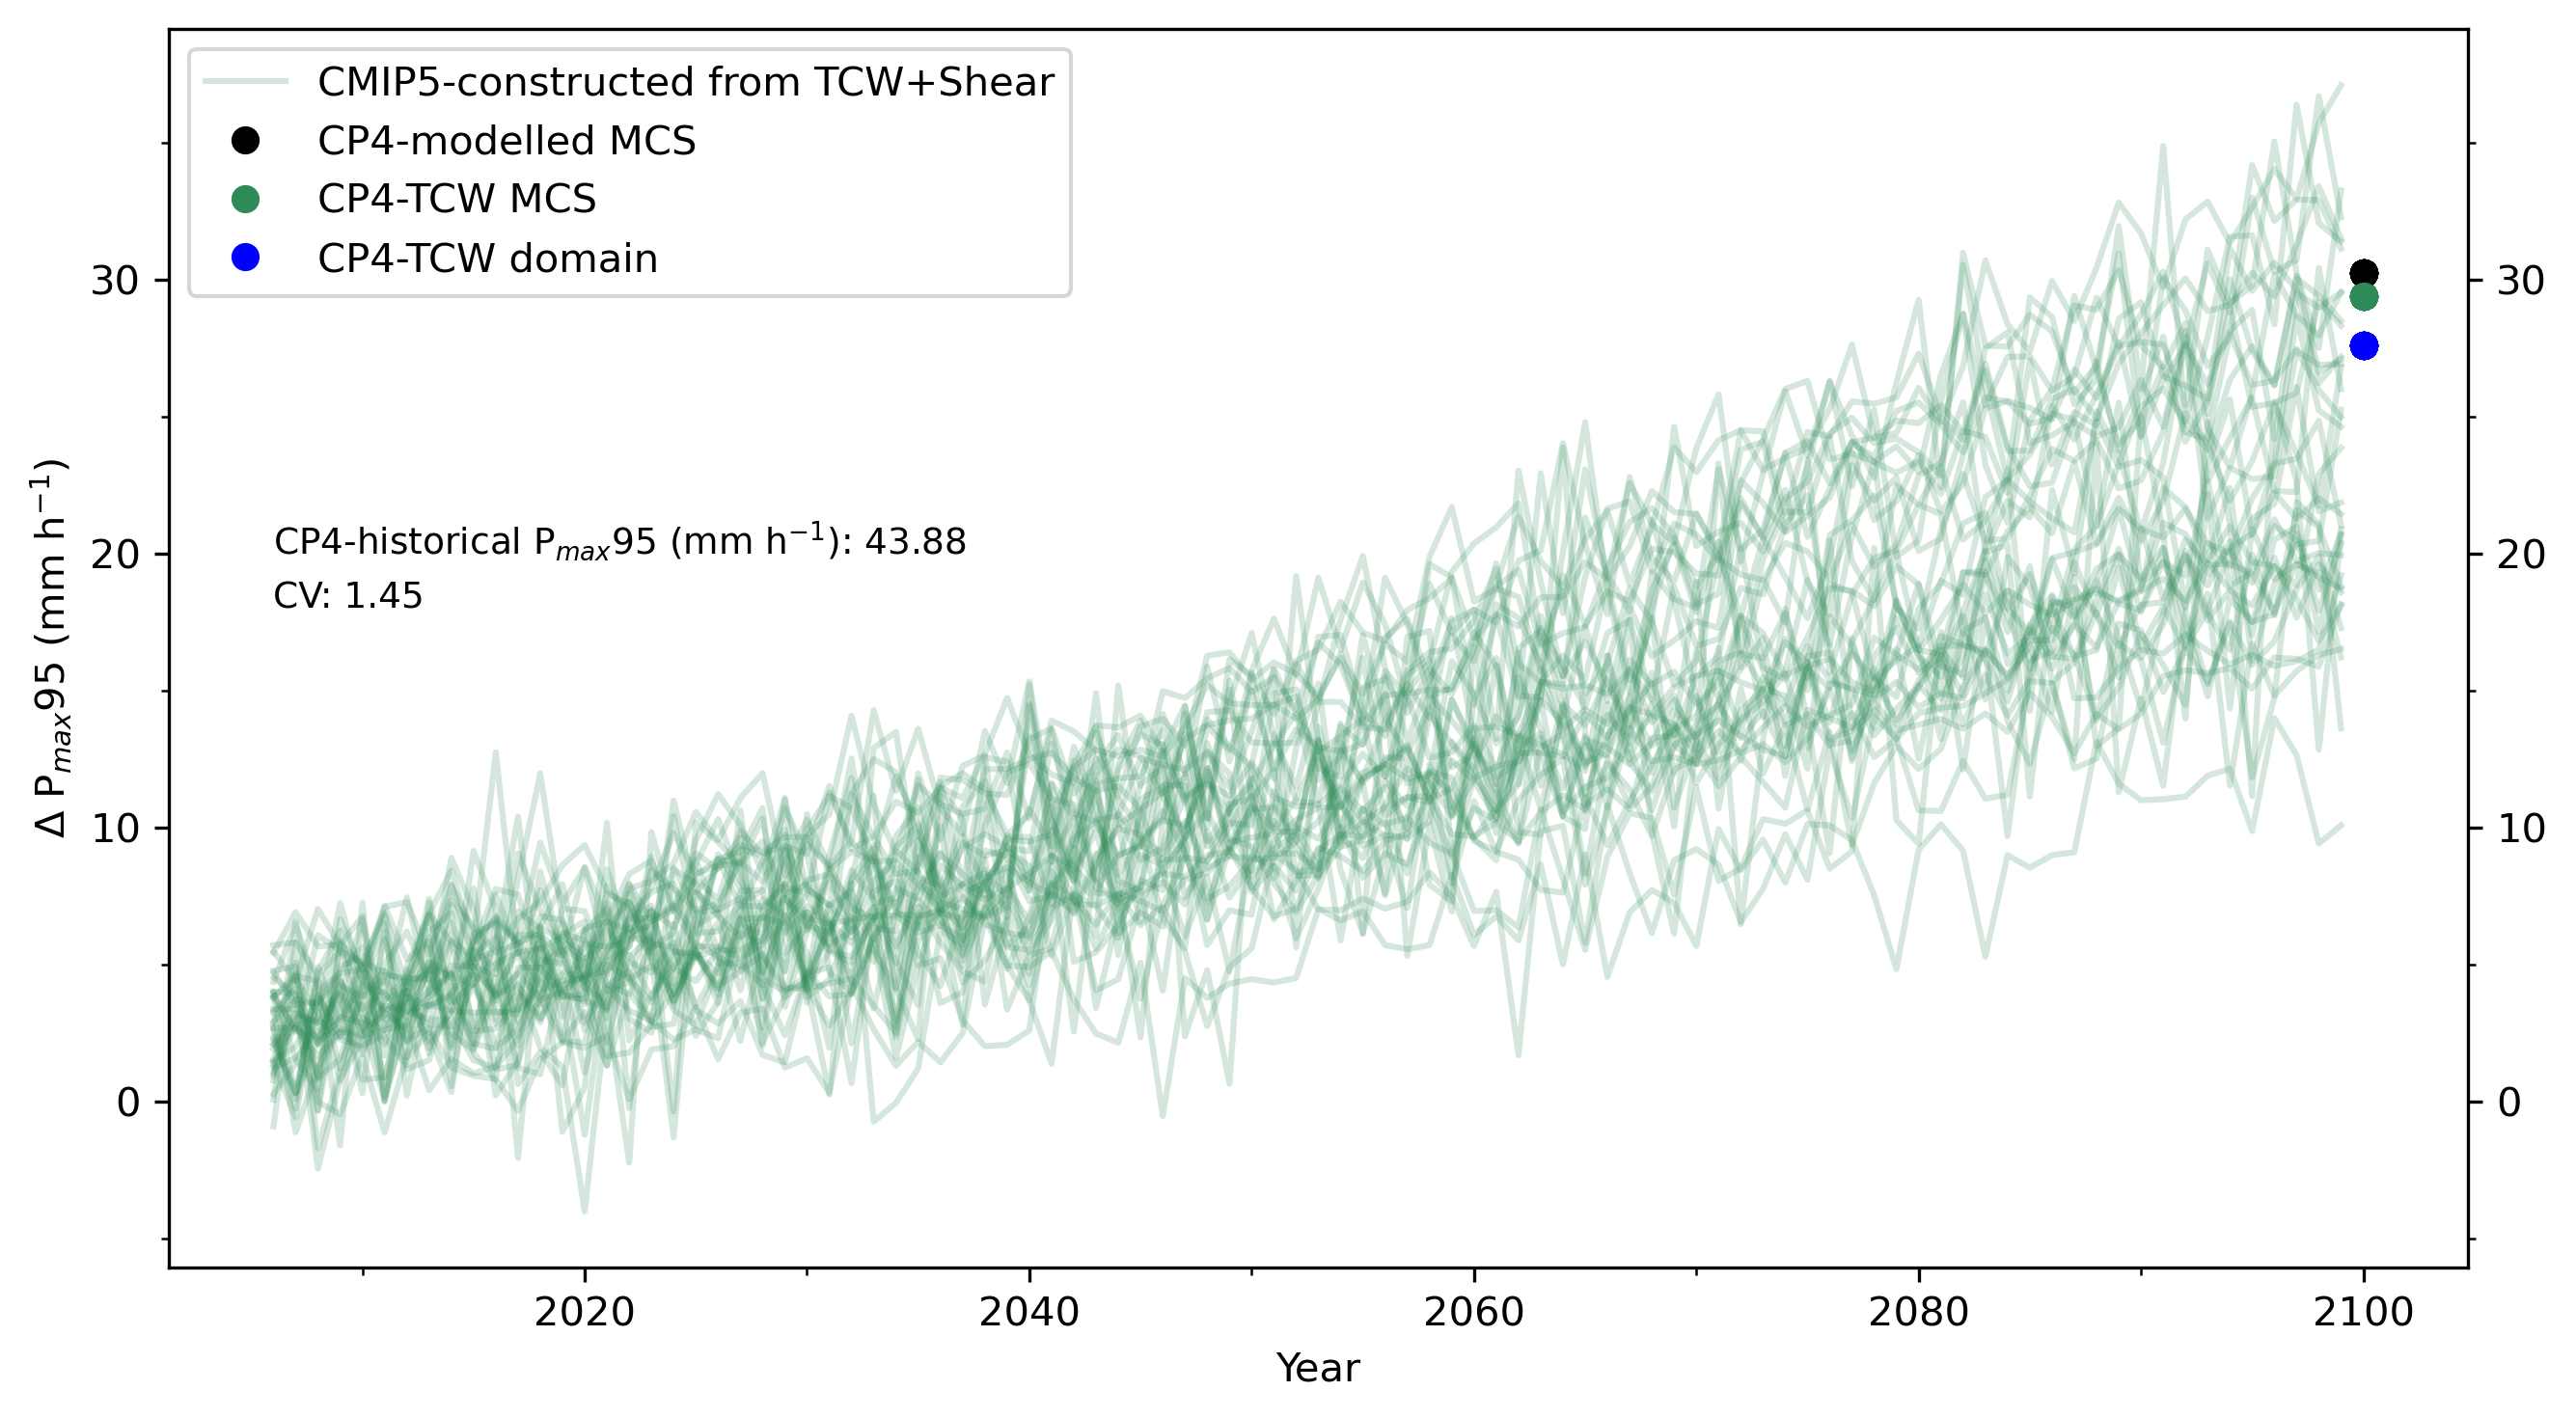

In [284]:


notfinite = np.isnan(cp4_pos_array)
f = plt.figure(figsize=(9,5), dpi=300)


ax = f.add_subplot(1,1,1)  #cp4f_mcs_grid-

slevels=np.arange(-18,19,3)
tag='10'
yy ='2020-2100'
#ipdb.set_trace()
evenly_spaced_interval = np.linspace(0, 1, len(model_names))

colors = [cm.inferno(x) for x in evenly_spaced_interval]
for ids, mn in enumerate(model_names.values):
    tcw_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+yy+'/prw_*_'+mn+'_*.nc')[0]).squeeze()
    sh_map = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_'+yy+'/u*_'+mn+'_*.nc')[0]).squeeze()
    
    tcw_map = tcw_map.where(tcw_map['time.year']<=2099, drop=True)
    sh_map = sh_map.where(sh_map['time.year']<=2099, drop=True)
    
    #ds_merge = xr.merge([tcw_map, sh_map])

    ##relative CMIP change
    ds_shear = sh_map['unknown']*shearfac
    cmip_rel = (tcw_map['prw'])

    years = np.unique(tcw_map['time.year'].values)

   # ipdb.set_trace()
    new_ar_list =   cmip_rel #*cp4_pos_array * cp4hist_mcs['prcp']
    sums = new_ar_list #+ ds_shear
    if len(sums)>95:
        ipdb.set_trace()
        
    cp4construct =   cp4_tcw_hist['tcwv'] #cp4hist_mcs['prcp'] * cp4_pos_array *
    cp4total = cp4_tcw_fut['tcwv']-cp4_tcw_hist['tcwv']#cp4construct + cp4_shear_abs['u_pl']
        
    ax.plot(tcw_map['time.year'].values,(sums)*1.3, color='seagreen', alpha=0.2, label='CMIP5-constructed from TCW+Shear')
    #ax.plot(tcw_map['time.year'].values,new_ar_list, color='slategrey', alpha=0.9, label='CMIP5')
    #ax.plot(2006, cp4hist_mcs['prcp'], marker='o', color='k')
    ax.plot(2100, cp4fut_mcs['prcp']-cp4hist_mcs['prcp'], marker='o', linestyle='', color='k', label='CP4-modelled MCS')
    ax.plot(2100, (cp4fut_mcs['tcwv']-cp4hist_mcs['tcwv'])*1.3, marker='o', color='seagreen', linestyle='', label='CP4-TCW MCS')
    ax.plot(2100, cp4total*1.3, marker='o', color='b', linestyle='', label='CP4-TCW domain')
# 
    
    if ids==0:
        plt.legend()
    
ax.text(2006,20,'CP4-historical P$_{max}$95 (mm h$^{-1}$): '+str(np.round(cp4hist_mcs['prcp'],2)), fontsize=9)
#ax.text(2006,18,'CP4 $\Delta$TCW (%): '+str(np.round(cp4_tcw_rel['tcwv'].values*100,2)), fontsize=8)
ax.text(2006,18,'CV: '+str(np.round(cp4_pos_array,2)), fontsize=9)
ax.set_ylabel('$\Delta$ P$_{max}$95 (mm h$^{-1}$)')
ax.set_xlabel('Year')
ax.tick_params(axis='y', which='both', labelright='off', labelleft='on', right='on')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
#ax.axhline(0, linestyle='solid', lw=1, color='k')



    
    #     new_ar_list.name = 'prw'
    #     ar_list.append(new_ar_list)

    # ds_scaled = xr.concat(ar_list, dim='model_name')
    # ds_merge['sum'] =  ds_shear +ds_scaled  #
    # ds_merge['contribution'] = ds_shear/ ds_merge['sum']*100

    # 
    # for mids in ds_merge['prw'].model_name:
    #     ax.plot(years, ds_merge['sum'].sel(model_name=mids))

plt.tight_layout()

#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP_Ouagadougou_timeseries_CP4_8mm.jpg')